In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

import IPython.display as dis
import matplotlib.animation as animation
from PIL import Image

import os
import pandas as pd
import seaborn as sns

import geopandas as gpd
import libpysal
import pysal
#from libpysal.weights.contiguity import Queen
from libpysal.weights import Queen, Rook, KNN, Kernel
from splot.libpysal import plot_spatial_weights

from shapely.ops import cascaded_union

/home/marek/.local/lib/python3.6/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [2]:
class Graph:
    def __init__(self, G):
        self.nodes = np.array(G.nodes())
        edges_arr = list(G.edges())
        self.edges = self.extract_edges( self.nodes, edges_arr, G )
        self.opinions = np.random.randint(2, size=self.nodes.size)
        #self.level = self.edges[0].shape[-1]
        self.voting_prefferences = np.zeros((self.nodes.size, 2))
        self.voting_prefferences[:,self.opinions] = 1
    
    def extract_edges(self, nodes, edges, g):
        d = dict.fromkeys(np.array(g.nodes()), [])
        for e in edges:
            d[e[0]]  = d[e[0]] + [e[1]]
        for e in edges:
            d[e[1]]  = d[e[1]] + [e[0]]
        for key in d.keys():
            d[key] = np.array(d[key])
        return d
    
    def one_step(self, noise=0):
        temp_opinions = np.copy(self.opinions.astype(int))
        for node in self.nodes:
            n0 = 0
            n1 = 0
            for neighbour in self.edges[node]:
                if self.opinions[neighbour] == 1: n1 +=1
                elif self.opinions[neighbour] == 0: n0 +=1
            if n1>n0: 
                temp_opinions[node] = 1
                self.voting_prefferences[node, 1] +=1
            elif n0>n1: 
                temp_opinions[node] = 0
                self.voting_prefferences[node, 0] +=1
            else:
                self.voting_prefferences[ node, int(temp_opinions[node]) ] +=1
            if np.random.random_sample() < noise:
                if temp_opinions[node] == 0: 
                    temp_opinions[node] = 1
                    self.voting_prefferences[node, 1] +=1
                else: 
                    temp_opinions[node] = 0
                    self.voting_prefferences[node, 0] +=1
            #print('node:',node,' n0,n1: ',n0,n1, ' opinion: ',self.opinions[node],'->'  ,temp_opinions[node])
        #self.opinions = temp_opinions
        
    def one_move(self):
        self.opinions = np.argmax(self.voting_prefferences, axis=1)
        self.voting_prefferences = np.zeros((self.nodes.size, 2))
        self.voting_prefferences[:,self.opinions] = 1
    
    def parties(self):
        op1 = np.where(self.opinions==1)
        op0 = np.where(self.opinions==0)
        party1 = self.nodes[op1]
        party0 = self.nodes[op0]
        return list(op0[0]), list(op1[0])

In [3]:
path = 'powiaty/powiaty.shp'
# https://github.com/Toblerity/Fiona/issues/548
powiaty = gpd.read_file(path) 
for i in range(len(powiaty.jpt_nazwa_)):
    powiaty.jpt_nazwa_[i] = powiaty.jpt_nazwa_[i].encode("latin1","strict").decode('utf-8')

/home/marek/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [4]:
path_w = 'wojewodztwa/województwa.shp'
# https://github.com/Toblerity/Fiona/issues/548
gdf = gpd.read_file(path_w) 
for i in range(len(gdf.jpt_nazwa_)):
    gdf.jpt_nazwa_[i] = gdf.jpt_nazwa_[i].encode("latin1","strict").decode('utf-8')

/home/marek/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [5]:
warszawski = cascaded_union([powiaty['geometry'][143], #warszawski
                             powiaty['geometry'][176], #wolominski
                             powiaty['geometry'][174], #legionowski
                             powiaty['geometry'][163], #wwa zach
                             powiaty['geometry'][150], #pruszowski
                             powiaty['geometry'][147], #piaseczynski
                             powiaty['geometry'][146], #otwocki
                             powiaty['geometry'][141], #nowodworski
                             powiaty['geometry'][170]  #grodziski
                            ])
mazowiecki = gdf['geometry'][3].difference(warszawski)
p_wm = cascaded_union([gdf['geometry'][5],gdf['geometry'][10] ])
m_s = cascaded_union([gdf['geometry'][11],gdf['geometry'][1] ])
d_o = cascaded_union([gdf['geometry'][0],gdf['geometry'][7] ])
l_zp = cascaded_union([gdf['geometry'][6],gdf['geometry'][12] ])

In [6]:
df = pd.DataFrame(
    {'Obszar': ['pomorskie', 'kujawsko-pomorskie', 'podlaskie_warmińsko-mazurskie', 'Warszawa', 
                'mazowieckie', 'łodzkie', 'wielkopolskie', 'lubelskie', 'podkarpackie',
                'małopolskie_świętokrzyskie', 'śląskie', 'dolnośląskie_opolskie', 'lubuskie_zachodniopomorskie'],
     'geometry': [gdf['geometry'][15], gdf['geometry'][2], p_wm, warszawski,
                  mazowiecki, gdf['geometry'][9], gdf['geometry'][8], gdf['geometry'][14], gdf['geometry'][13],
                  m_s, gdf['geometry'][4], d_o, l_zp]})
euro = gpd.GeoDataFrame(df)

In [7]:
weuro = Queen.from_dataframe(euro)

In [8]:
pos_e = {}

woj = euro
woj['centroid'] = woj['geometry'].centroid
for point in woj.iterrows():
    pos_e[point[0]] = [point[1]['centroid'].x, point[1]['centroid'].y]

In [9]:
contig_matrix = weuro

# build list of edges - this will create edges going both ways from connected nodes, so you might need to remove duplicates
nodes = contig_matrix.weights.keys()  # to get dict of keys, alternatively use contig_matrix.id2i.keys()
edges = [(node, neighbour) for node in nodes for neighbour in contig_matrix[node]]
graph_euro = nx.Graph(edges)

pos_e[4] = [pos_e[4][0]+50000, pos_e[4][1]]

In [10]:
graph_euro.add_edge(3, 4)
graph_euro.add_edge(12, 0)
graph_euro.add_edge(6, 0)

In [11]:
labels_e={}
for i in range(len(graph_euro)):
    labels_e[i]=i+1

/home/marek/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


{0: Text(433922.6820094637, 699365.4413247135, '1'),
 1: Text(465842.30054796615, 578593.4746001965, '2'),
 2: Text(684583.9411240611, 639813.5850737185, '3'),
 3: Text(636390.4502996295, 489068.70088376437, '4'),
 4: Text(694092.105699006, 500980.4114461026, '5'),
 5: Text(528825.0792980572, 415319.2622335898, '6'),
 6: Text(380773.2949716981, 497126.4502542682, '7'),
 7: Text(772477.095949457, 379460.8926254698, '8'),
 8: Text(727321.1026623963, 236412.63229461695, '9'),
 9: Text(605865.5741522586, 266115.99789024296, '10'),
 10: Text(499481.2070232351, 273446.71210858814, '11'),
 11: Text(351895.9227878372, 344571.5973499544, '12'),
 12: Text(262933.74779690854, 582558.7293352747, '13')}

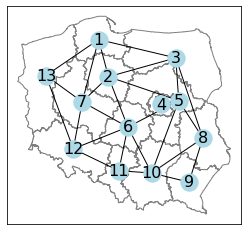

In [12]:
ax = euro.plot(edgecolor='grey', facecolor='w')

nx.draw_networkx_edges(graph_euro,pos_e)
nx.draw_networkx_nodes(graph_euro,pos_e, node_color='lightblue'),

nx.draw_networkx_labels(graph_euro,pos_e,labels_e,font_size=16)
#https://gis.stackexchange.com/questions/197652/find-common-borders-of-features-and-get-their-attributes-using-fiona-and-shapely
#borders
#plt.savefig('polska_euro.png',  bbox_inches = 'tight')

In [13]:
gE = Graph(graph_euro)
#1 po
#0 pis

Text(0.5, 1, 'Wybory do europaramentu 2019')

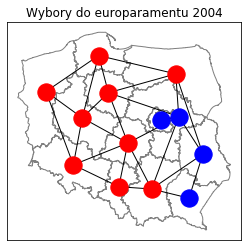

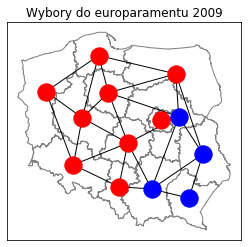

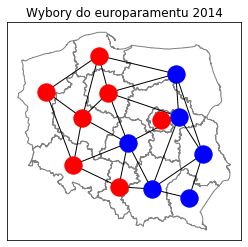

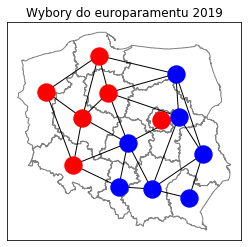

In [14]:
gE.opinions = np.ones(len(gE.opinions))
gE.opinions[[3,4, 7,8]] = 0
party0, party1 = gE.parties()

ax = euro.plot(edgecolor='grey', facecolor='w')
nx.draw_networkx_edges(graph_euro, pos_e)
nx.draw_networkx_nodes(graph_euro, pos_e, nodelist=party0, node_color='b')
nx.draw_networkx_nodes(graph_euro, pos_e, nodelist=party1, node_color='r')
plt.title('Wybory do europaramentu 2004')
#plt.savefig('polska_euro2004.png',  bbox_inches = 'tight')

gE.opinions = np.ones(len(gE.opinions))
gE.opinions[[4,7, 8,9]] = 0
party0, party1 = gE.parties()

ax = euro.plot(edgecolor='grey', facecolor='w')
nx.draw_networkx_edges(graph_euro, pos_e)
nx.draw_networkx_nodes(graph_euro, pos_e, nodelist=party0, node_color='b')
nx.draw_networkx_nodes(graph_euro, pos_e, nodelist=party1, node_color='r')
plt.title('Wybory do europaramentu 2009')
plt.savefig('polska_euro2009.png',  bbox_inches = 'tight')#

gE.opinions = np.ones(len(gE.opinions))
gE.opinions[[2, 4,5, 7, 8,9]] = 0
party0, party1 = gE.parties()

ax = euro.plot(edgecolor='grey', facecolor='w')
nx.draw_networkx_edges(graph_euro, pos_e)
nx.draw_networkx_nodes(graph_euro, pos_e, nodelist=party0, node_color='b')
nx.draw_networkx_nodes(graph_euro, pos_e, nodelist=party1, node_color='r')
plt.title('Wybory do europaramentu 2014')
#plt.savefig('polska_euro2014.png',  bbox_inches = 'tight')

gE.opinions = np.ones(len(gE.opinions))
gE.opinions[[2, 4,5, 7, 8,9, 10]] = 0
party0, party1 = gE.parties()

ax = euro.plot(edgecolor='grey', facecolor='w')
nx.draw_networkx_edges(graph_euro, pos_e)
nx.draw_networkx_nodes(graph_euro, pos_e, nodelist=party0, node_color='b')
nx.draw_networkx_nodes(graph_euro, pos_e, nodelist=party1, node_color='r')
plt.title('Wybory do europaramentu 2019')
#plt.savefig('polska_euro2019.png',  bbox_inches = 'tight')

In [15]:
gE.opinions = np.ones(len(gE.opinions))
gE.opinions[[3,4, 7,8]] = 0

Text(0.5, 1, 'Wybory do europaramentu 12')

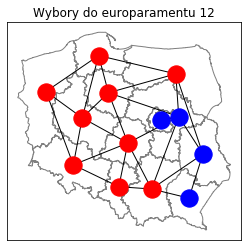

In [16]:
gE.one_step()
party0, party1 = gE.parties()

ax = euro.plot(edgecolor='grey', facecolor='w')
nx.draw_networkx_edges(graph_euro, pos_e)
nx.draw_networkx_nodes(graph_euro, pos_e, nodelist=party0, node_color='b')
nx.draw_networkx_nodes(graph_euro, pos_e, nodelist=party1, node_color='r')
plt.title('Wybory do europaramentu '+str(i))

In [17]:
for it in range(1000):
    gE = Graph(graph_euro)
    gE.opinions = np.ones(len(gE.opinions))
    gE.opinions[[3,4, 7,8]] = 0
    
    j = 0
    voters0 = []
    voters1 = []
    #for j in range(10):
    while np.sum(gE.opinions) != len(gE.opinions) and np.sum(gE.opinions) != 0 and j<20:
        voters0.append(np.sum(gE.opinions)/len(gE.opinions))
        voters1.append(1-np.sum(gE.opinions)/len(gE.opinions))
        gE.one_step(0.1) 
        j+=1

    voters0.append(np.sum(gE.opinions)/len(gE.opinions))
    voters1.append(1-np.sum(gE.opinions)/len(gE.opinions))

    with open('polsza/polskaSteps', "a+") as f:
                    if(voters0[-1]>voters1[-1]):
                        for v0 in voters0:
                            f.write(str(v0) + ' ')
                    else:
                        for v0 in voters1:
                            f.write(str(v0) + ' ')
                    f.write("\n")

In [18]:
my_cols = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]
path0 = 'polsza/polskaNoise10'
vp = pd.read_csv(path0, sep=" ", names=my_cols, engine='python').T.fillna(method='ffill')
vp['std'] = vp.std(axis=1)
vp['mean'] = vp.mean(axis=1)

FileNotFoundError: [Errno 2] No such file or directory: 'polsza/polskaNoise10'

NameError: name 'vp' is not defined

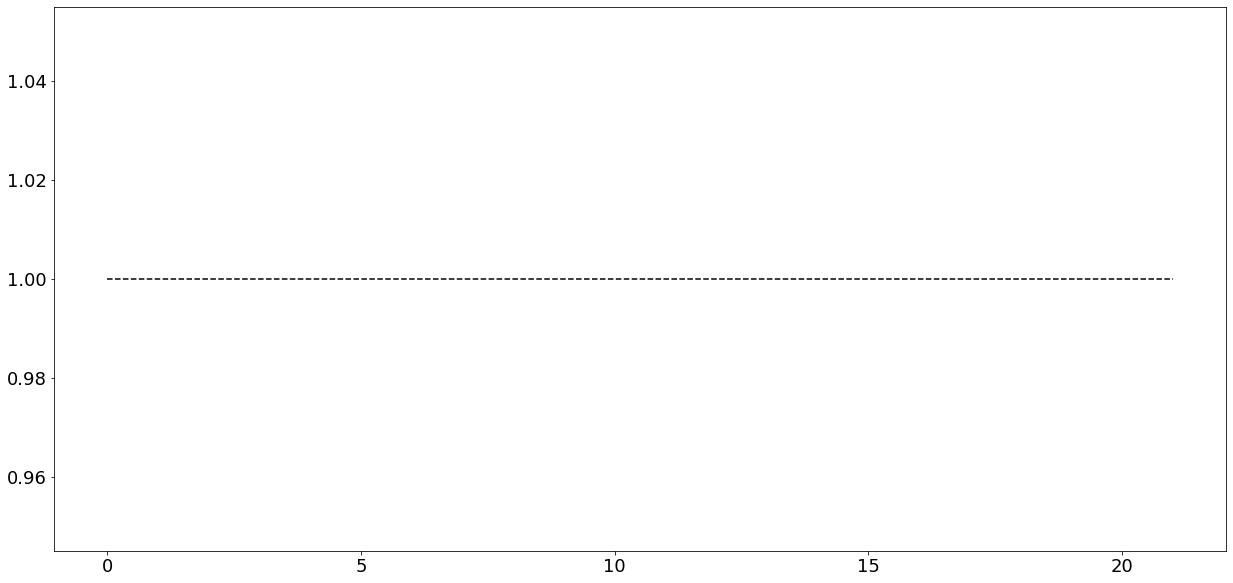

In [19]:
plt.figure(figsize=(21, 10))
plt.rcParams.update({'font.size': 18})

plt.plot([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1], '--', c='black')
plt.errorbar(my_cols, vp['mean'], vp['std'], linestyle='None', marker='o', capsize=5)
plt.ylim(top=1.2, bottom=0)  

plt.suptitle('Stosunek liczby popleczników dominującej partii \n do liczby wszystkich agentów dla Polski \n dla wyników z 2005')
plt.xlabel("Krok czasowy")

plt.ylabel(r"Stosunek agentów danej partii $\frac{n_i}{N}$")

In [20]:
for it in range(1000):
    gE = Graph(graph_euro)
    
    j = 0
    voters0 = []
    voters1 = []
    #for j in range(10):
    while np.sum(gE.opinions) != len(gE.opinions) and np.sum(gE.opinions) != 0 and j<20:
        voters0.append(np.sum(gE.opinions)/len(gE.opinions))
        voters1.append(1-np.sum(gE.opinions)/len(gE.opinions))
        gE.one_step(0.1) 
        j+=1

    voters0.append(np.sum(gE.opinions)/len(gE.opinions))
    voters1.append(1-np.sum(gE.opinions)/len(gE.opinions))

    with open('polsza/polskaNoise10rand', "a+") as f:
                    if(voters0[-1]>voters1[-1]):
                        for v0 in voters0:
                            f.write(str(v0) + ' ')
                    else:
                        for v0 in voters1:
                            f.write(str(v0) + ' ')
                    f.write("\n")

In [21]:
my_cols = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]
path0 = 'polsza/polskaNoise10rand'
vp = pd.read_csv(path0, sep=" ", names=my_cols, engine='python').T.fillna(method='ffill')
vp['std'] = vp.std(axis=1)
vp['mean'] = vp.mean(axis=1)

Text(0, 0.5, 'Stosunek agentów danej partii $\\frac{n_i}{N}$')

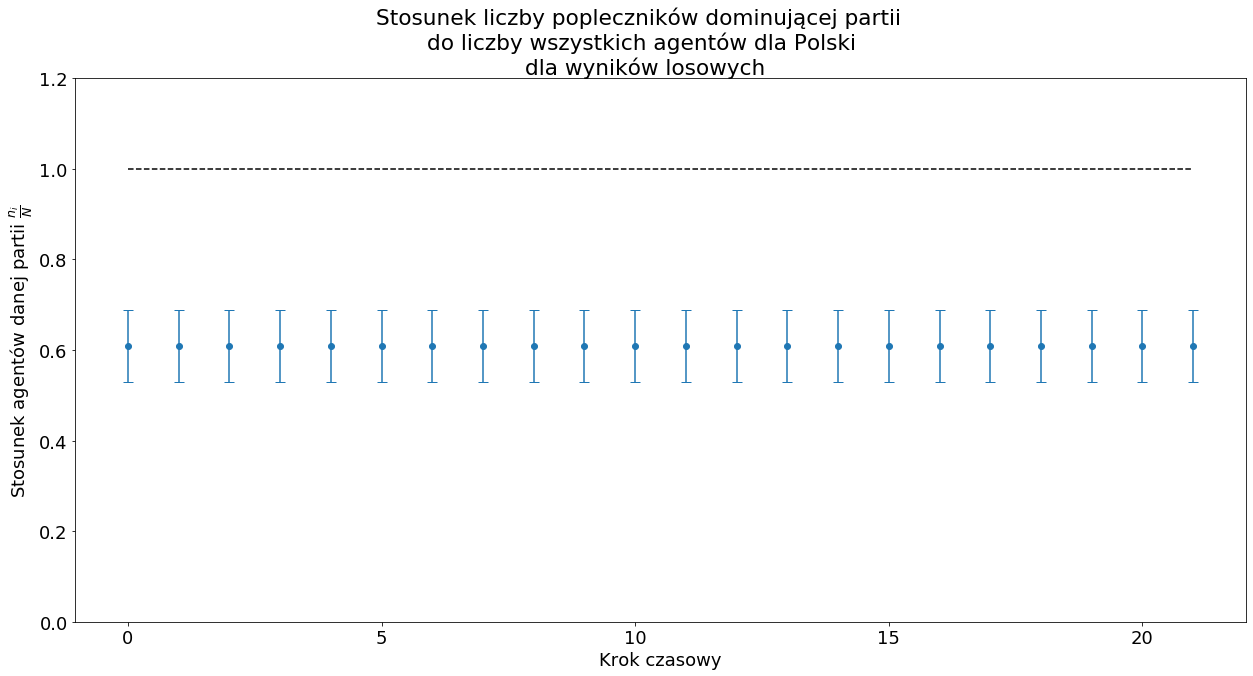

In [22]:
plt.figure(figsize=(21, 10))
plt.rcParams.update({'font.size': 18})

plt.plot([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1], '--', c='black')
plt.errorbar(my_cols, vp['mean'], vp['std'], linestyle='None', marker='o', capsize=5)
plt.ylim(top=1.2, bottom=0)  

plt.suptitle('Stosunek liczby popleczników dominującej partii \n do liczby wszystkich agentów dla Polski \n dla wyników losowych')
plt.xlabel("Krok czasowy")

plt.ylabel(r"Stosunek agentów danej partii $\frac{n_i}{N}$")

In [23]:
path0 = 'polsza/polskaSteps'
for it in range(1000):
    gE = Graph(graph_euro)
    gE.opinions = np.ones(len(gE.opinions))
    gE.opinions[[3,4, 7,8]] = 0
    
    j = 0
    voters0 = []
    voters1 = []
    #for j in range(10):
    
    while np.sum(gE.opinions) != len(gE.opinions) and np.sum(gE.opinions) != 0 and j<20:
        gE.one_step(0.05) 
        j+=1
        if j%4 == 0:
            voters0.append(np.sum(gE.opinions)/len(gE.opinions))
            voters1.append(1-np.sum(gE.opinions)/len(gE.opinions))
            gE.one_move()

    voters0.append(np.sum(gE.opinions)/len(gE.opinions))
    voters1.append(1-np.sum(gE.opinions)/len(gE.opinions))

    with open(path0, "a+") as f:
                    if(voters0[-1]>voters1[-1]):
                        for v0 in voters0:
                            f.write(str(v0) + ' ')
                    else:
                        for v0 in voters1:
                            f.write(str(v0) + ' ')
                    f.write("\n")

In [24]:
my_cols = [0,1,2,3,4,5,6]
vp = pd.read_csv(path0, sep=" ", names=my_cols, engine='python').T.fillna(method='ffill')
vp['std'] = vp.std(axis=1)
vp['mean'] = vp.mean(axis=1)

plt.figure(figsize=(21, 10))
plt.rcParams.update({'font.size': 18})

plt.plot([1,1,1,1,1,1,1], '--', c='black')
plt.errorbar(my_cols, vp['mean'], vp['std'], linestyle='None', marker='o', capsize=5)
plt.ylim(top=1.2, bottom=0)  

plt.suptitle('Stosunek liczby popleczników dominującej partii \n do liczby wszystkich agentów dla Polski \n dla wyników losowych')
plt.xlabel("Krok czasowy")

plt.ylabel(r"Stosunek agentów danej partii $\frac{n_i}{N}$")

ParserError: Expected 7 fields in line 1001, saw 22

In [ ]:
vgE = np.empty( (100,), dtype=object)

In [ ]:
vgE[:] = Graph(graph_euro)

In [ ]:
vgE[1].nodes

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def sigmoid(x):
    return 1/(1+ np.exp(1-x))

In [ ]:
vsig = np.vectorize(sigmoid)
x = np.arange(-5, 5, 0.05)

In [ ]:
y = vsig(x)

In [ ]:
plt.plot(x, y)

## PART 2

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

import IPython.display as dis
import matplotlib.animation as animation
from PIL import Image

import os
import pandas as pd
import seaborn as sns

import geopandas as gpd
import libpysal
import pysal
# from libpysal.weights.contiguity import Queen
from libpysal.weights import Queen, Rook, KNN, Kernel
from splot.libpysal import plot_spatial_weights

from shapely.ops import cascaded_union


class Graph:
    def __init__(self, G):
        self.nodes = np.array(G.nodes())
        edges_arr = list(G.edges())
        self.edges = self.extract_edges(self.nodes, edges_arr, G)
        self.opinions = np.random.randint(2, size=self.nodes.size)
        # self.level = self.edges[0].shape[-1]
        self.voting_prefferences = np.ones((self.nodes.size, 2))
        #self.voting_prefferences[:, self.opinions] = 1

    def extract_edges(self, nodes, edges, g):
        d = dict.fromkeys(np.array(g.nodes()), [])
        for e in edges:
            d[e[0]] = d[e[0]] + [e[1]]
        for e in edges:
            d[e[1]] = d[e[1]] + [e[0]]
        for key in d.keys():
            d[key] = np.array(d[key])
        return d

    def one_step(self, alpha, noise=0):
        temp_opinions = np.copy(self.opinions)
        for node in self.nodes:
            n0 = 0
            n1 = 0
            n = len(self.edges[node])
            for neighbour in self.edges[node]:
                if self.opinions[neighbour] == 1:
                    n1 += 1
                elif self.opinions[neighbour] == 0:
                    n0 += 1

            if n1 > n0:
                temp_opinions[node] = 1
            elif n0 > n1:
                temp_opinions[node] = 0

            a0, a1 = 0, 0
            if np.random.random_sample() < noise:
                if temp_opinions[node] == 0:
                    a1 = 1
                else:
                    a0 = 1

            if temp_opinions[node] == 0:
                self.voting_prefferences[node, 0] += (n0 + 1 + a0) / n
                self.voting_prefferences[node, 1] += (n1 + a1) / n
            else:
                self.voting_prefferences[node, 1] += (n1 + 1 + a1) / n
                self.voting_prefferences[node, 0] += (n0 + a0) / n

            # print('node:',node,' n0,n1: ',n0,n1, ' opinion: ',self.opinions[node],'->'  ,temp_opinions[node])
        self.voting_prefferences = self.voting_prefferences * alpha.reshape(13, 2)

    def one_move(self):
        self.opinions = np.argmax(self.voting_prefferences, axis=1)
        #self.voting_prefferences = np.zeros((self.nodes.size, 2))
        #self.voting_prefferences[:, self.opinions] = 1

    def parties(self):
        op1 = np.where(self.opinions == 1)
        op0 = np.where(self.opinions == 0)
        party1 = self.nodes[op1]
        party0 = self.nodes[op0]
        return list(op0[0]), list(op1[0])

/home/marek/.local/lib/python3.6/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [2]:
euro = gpd.read_file("euro/euro.shp")

weuro = Queen.from_dataframe(euro)
pos_e = {}

woj = euro
woj['centroid'] = woj['geometry'].centroid
for point in woj.iterrows():
    pos_e[point[0]] = [point[1]['centroid'].x, point[1]['centroid'].y]

contig_matrix = weuro

# build list of edges - this will create edges going both ways from connected nodes, so you might need to remove duplicates
nodes = contig_matrix.weights.keys()  # to get dict of keys, alternatively use contig_matrix.id2i.keys()
edges = [(node, neighbour) for node in nodes for neighbour in contig_matrix[node]]
graph_euro = nx.Graph(edges)

pos_e[4] = [pos_e[4][0] + 50000, pos_e[4][1]]

graph_euro.add_edge(3, 4)
graph_euro.add_edge(12, 0)
graph_euro.add_edge(6, 0)

labels_e = {}
for i in range(len(graph_euro)):
    labels_e[i] = i + 1

gE = Graph(graph_euro)

op2009 = np.ones(len(gE.opinions))
op2009[[4, 7, 8, 9]] = 0

op2014 = np.ones(len(gE.opinions))
op2014[[2, 4, 5, 7, 8, 9]] = 0

op2019 = np.ones(len(gE.opinions))
op2019[[2, 4, 5, 7, 8, 9, 10]] = 0

opinion_arr = [op2009, op2014, op2019]

In [5]:
parameter1 = np.fromstring('0.023756457765446656 0.5633382126875802 0.33915336654728223 0.4115316630264049 0.9804097686282733 0.4762462342128407 0.1072024758178421 0.6868474902259009 0.26094592158458946 0.42699388565653906 0.5993330027151821 0.5196467440915867 0.3500708025742209 0.8420836817670585 0.6054322048843772 0.4863156358404752 0.8321364818399454 0.6567315806753641 0.893621800800366 0.4561245458193595 0.7885925922984101 0.3443805220522544 0.30845211165595765 0.4155645653073518 0.6881527326713318 0.8261937413856438 ',
                          sep = ' ')
#parameter1[11] = 0.1
#parameter1[12] = 0.9
s39_11 = '0.3570781305701005 0.5567599809055072 0.2583527682463479 0.6553049455555447 0.5808983514089876 0.39016587732053876 0.23513135432425733 0.7466876056768194 0.6333864618062387 0.42302139307109854 0.3939142847238097 0.5170854523136227 0.30356286352017015 0.5543692302304648 0.5368100549375114 0.45101367598025593 0.4666542049025729 0.5015096667107792 0.46354142782040486 0.5830186219841781 0.5702558072775934 0.5441721923457005 0.44155679377695817 0.4952490960465979 0.43111959510598935 0.6524177366897955 '
parameter11 = np.fromstring(s39_11, sep = ' ')

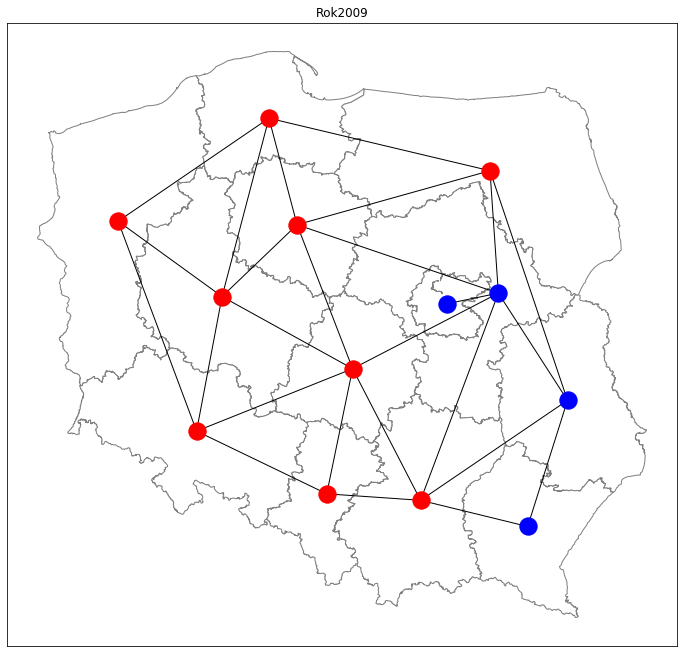

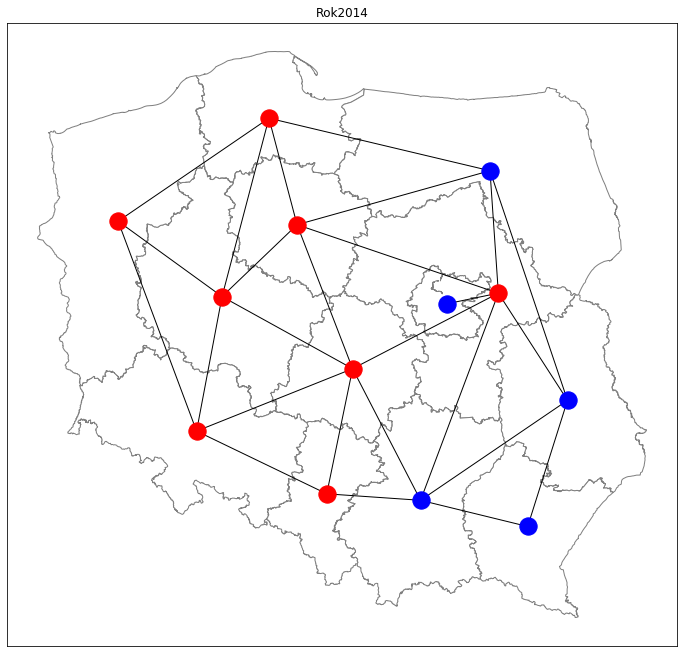

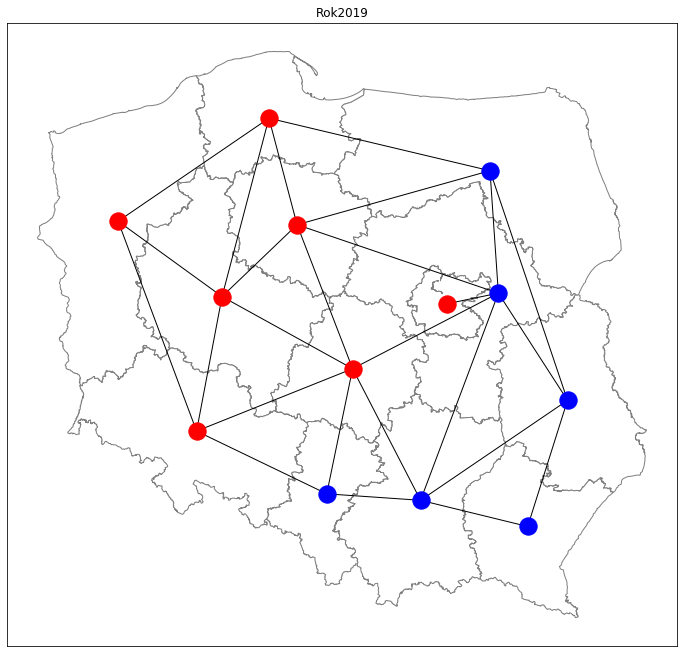

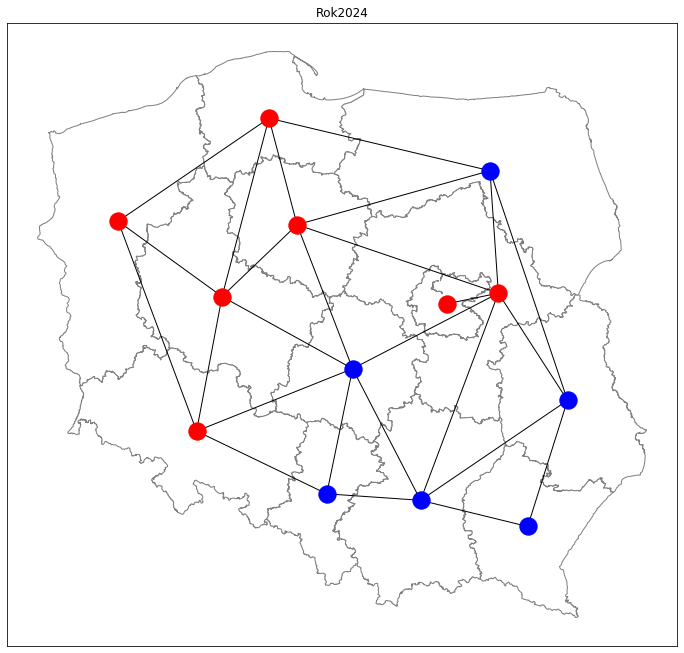

In [6]:
gE = Graph(graph_euro)
gE.opinions = np.ones(len(gE.opinions))
gE.opinions[[3, 4, 7, 8]] = 0
for j in range(20):
        party0, party1 = gE.parties()
        
        gE.one_step(parameter1,  0.05)
        if (j+1) % 5 == 0:
            gE.one_move()
            plt.rcParams["figure.figsize"] = (12,12)
            ax = euro.plot(edgecolor='grey', facecolor='w')
            nx.draw_networkx_edges(graph_euro, pos_e)
            nx.draw_networkx_nodes(graph_euro, pos_e, nodelist=party0, node_color='b')
            nx.draw_networkx_nodes(graph_euro, pos_e, nodelist=party1, node_color='r')
            plt.title('Rok'+str(2004+j+1))
            plt.savefig('polsza/move_every5_years_rok'+str(2004+j+1)+'.png', bbox_inches = 'tight')

In [76]:
s39_1 = '0.14416358125963474 0.5475189387641526 0.40135090185078204 0.6404307759607613 0.6534521448938496 0.5156959956846161 0.20138556690746293 0.591082773029314 0.5766903006523528 0.5279689598099296 0.513595861858303 0.39335118224499477 0.5685172991800773 0.5070847302142121 0.6444813118711987 0.4442270313004444 0.6237200658383751 0.40890532378972416 0.5514183734947982 0.4511138651603051 0.5860538982063714 0.5188510714471173 0.49228097054656794 0.5707884214277922 0.458751051402582 0.45418643117397217 '
s39_2 = '0.13410550931612597 0.5569339894775083 0.41906117576266255 0.6380772932976913 0.6544225400271654 0.5121485732639687 0.18680168449195586 0.5958465668973564 0.5863738035544124 0.5173696703523811 0.5155316498529308 0.4116666307718957 0.5915924310677968 0.5041175303396735 0.6385312821490572 0.44785673910653845 0.6279385829033126 0.41618705765575137 0.553426717715154 0.4445483901768081 0.581377763231472 0.5210304826970695 0.48923734339919106 0.5697051558131485 0.47283008442116303 0.4491022748882999'
s39_3 = '0.4677509684908781 0.45110587773416655 0.22801419793002933 0.4633680005968053 0.3028963640755068 0.20357890515414465 0.17607065600526764 0.5473784079776695 0.4723959555931123 0.1860444325801289 0.3973620774285281 0.34592584983421987 0.3448031030616292 0.4115347436398753 0.46581824183763476 0.435490244235071 0.22552578310769386 0.43739835062775184 0.3978967859745398 0.24381974996131422 0.42630375599187553 0.34661605645968047 0.31529615638478103 0.36981656800490204 0.13792294528591387 0.3703109313628083 '
s39_4 = '0.33870821212515767 0.30991133222764194 0.15468411844031527 0.3365021535275678 0.21840983351940532 0.14404036687694388 0.11519551003078393 0.3794828449953426 0.34197700417654575 0.12695267252113224 0.2764224347910427 0.25004481215314023 0.24131900465317463 0.30343058209707247 0.3095694388989964 0.30509595953275576 0.1556941676974824 0.3101735366432892 0.2718962517900943 0.18458556180945043 0.2929704465787624 0.25453884351175143 0.21452226784330572 0.2507628274902282 0.09704324235898458 0.27573062284782884 '
s39_5 = '0.37741268114578463 0.5579861994254085 0.526160637951625 0.5310275435004835 0.5036747049058907 0.25201352122608967 0.453514701846685 0.49725938040604495 0.5455586126322416 0.3391933052722496 0.39073880964504343 0.23269916076548558 0.25744681618942694 0.517334636716408 0.692000366727789 0.5801684369260356 0.8513751277283677 0.7112214433630515 0.543070173672787 0.5797829513356717 0.5168034360765476 0.2832395215853484 0.7020912806394721 0.6445641562126729 0.822731269643445 0.48959163563896874 '
s39_6 = '0.47376241560957966 0.3152088457166301 0.18806644358906602 0.3529768971699226 0.33719097283713056 0.2953951862592927 0.051815347361089156 0.46705127152047654 0.4184176656191818 0.22180550603206128 0.4719325102597233 0.14190314903910883 0.18391970960298631 0.27091458095733717 0.26980103112891346 0.19908848347702143 0.3055974847561601 0.2763521628028018 0.4659667406721801 0.35312914418653285 0.39200355707570894 0.2858705994075263 0.25048401767342593 0.442117081418004 0.2942892614682933 0.26948447434676354 '
parameter2 = np.fromstring(s39_6, sep = ' ')

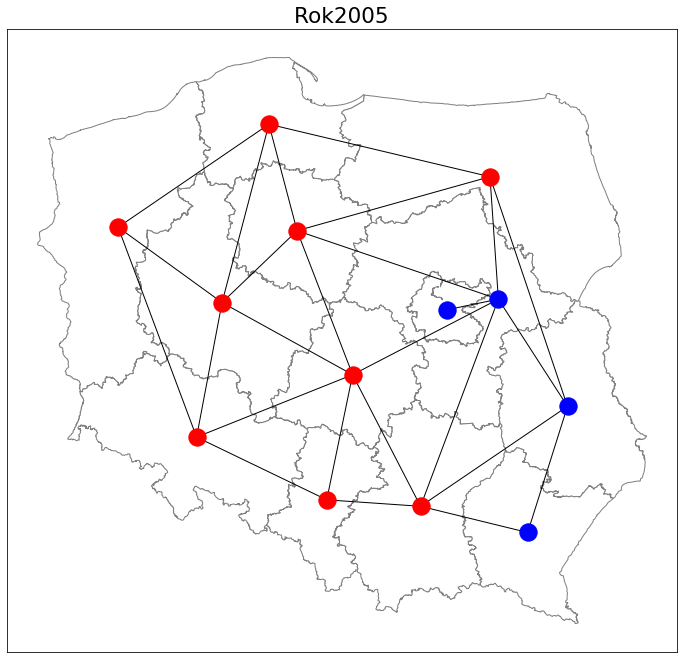

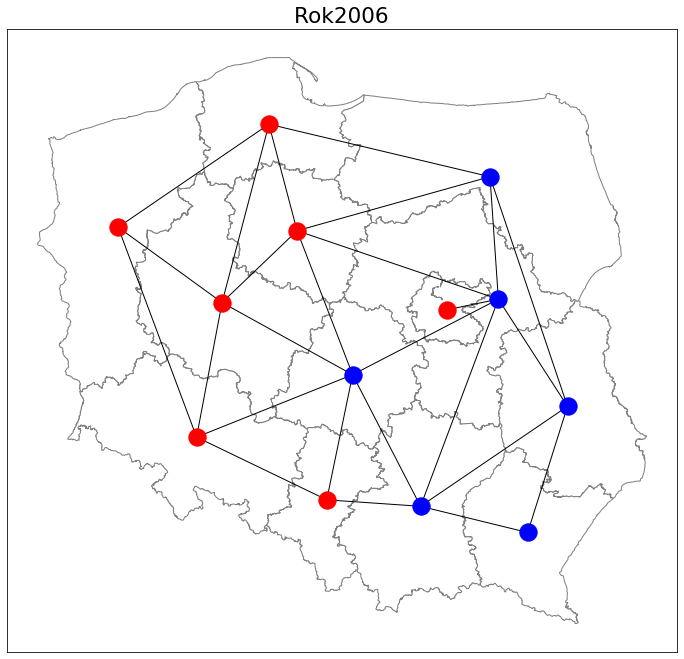

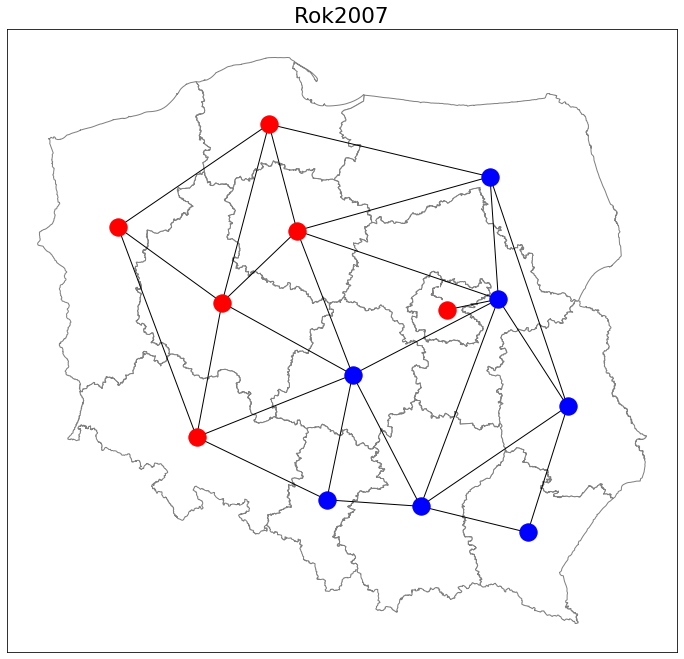

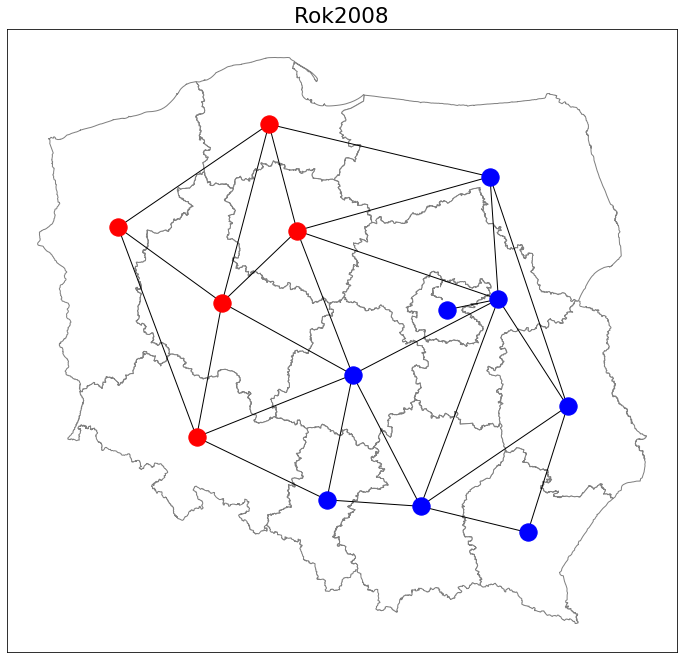

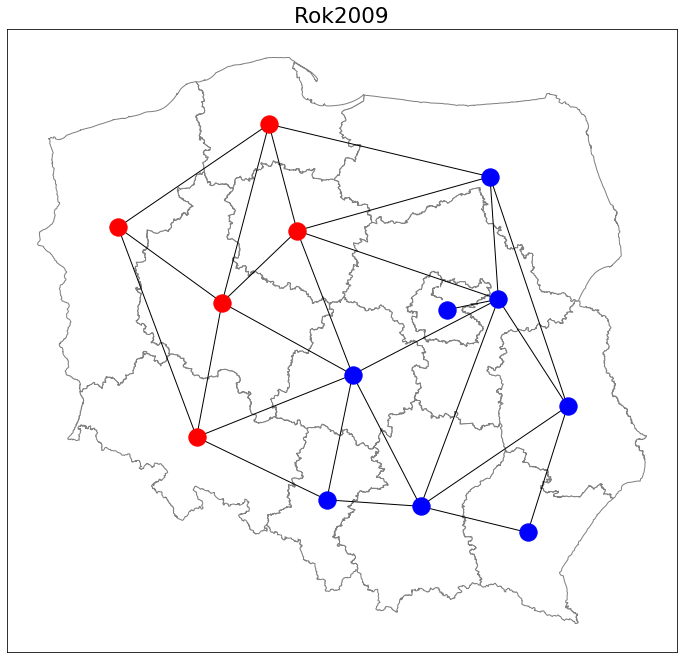

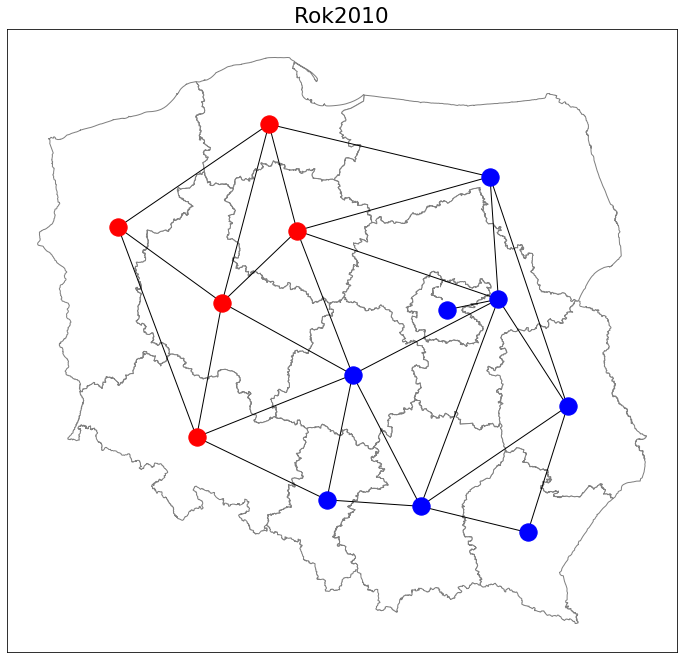

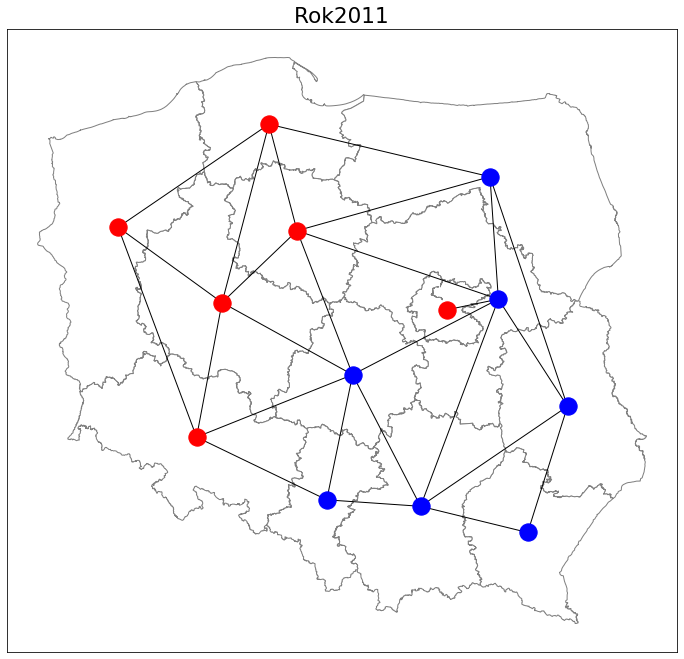

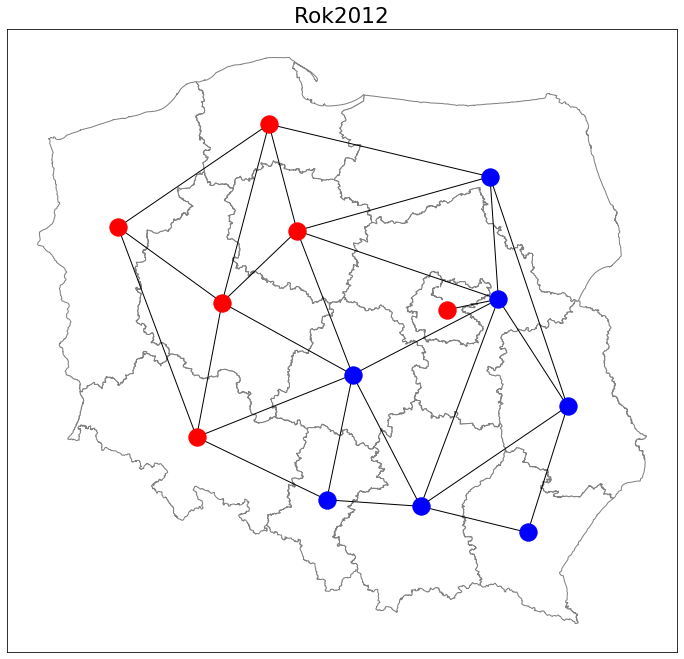

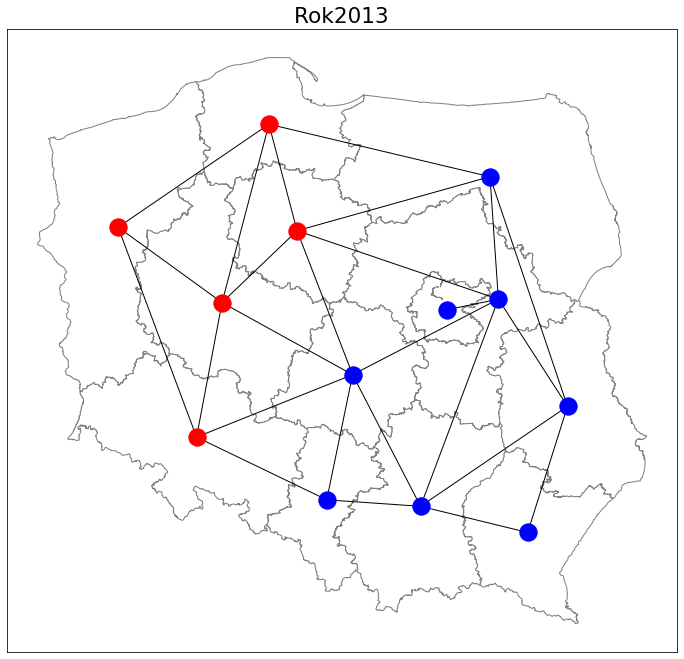

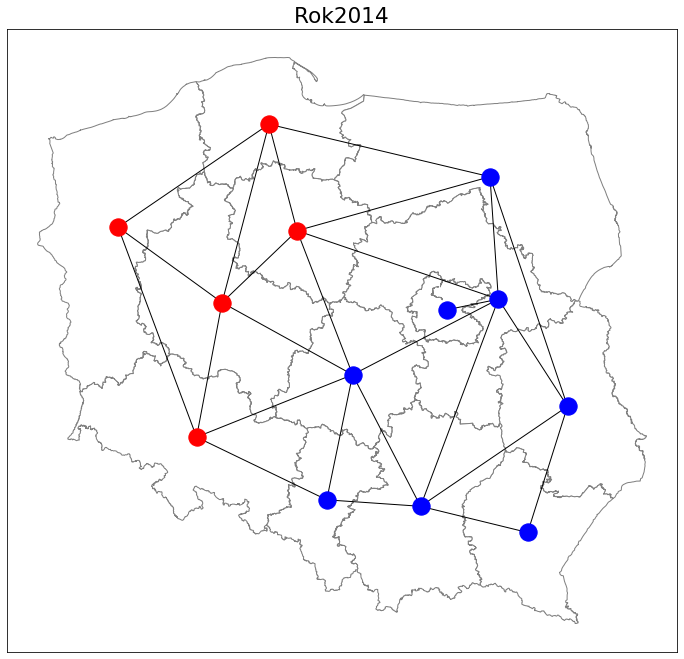

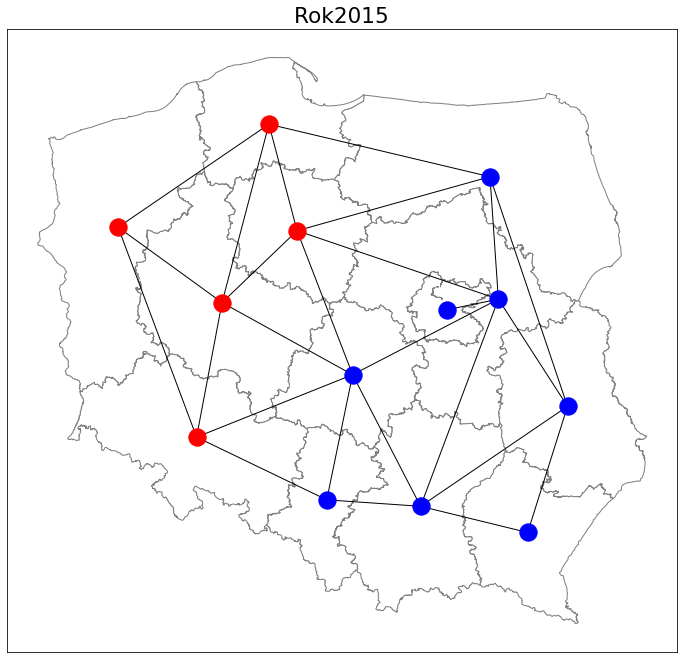

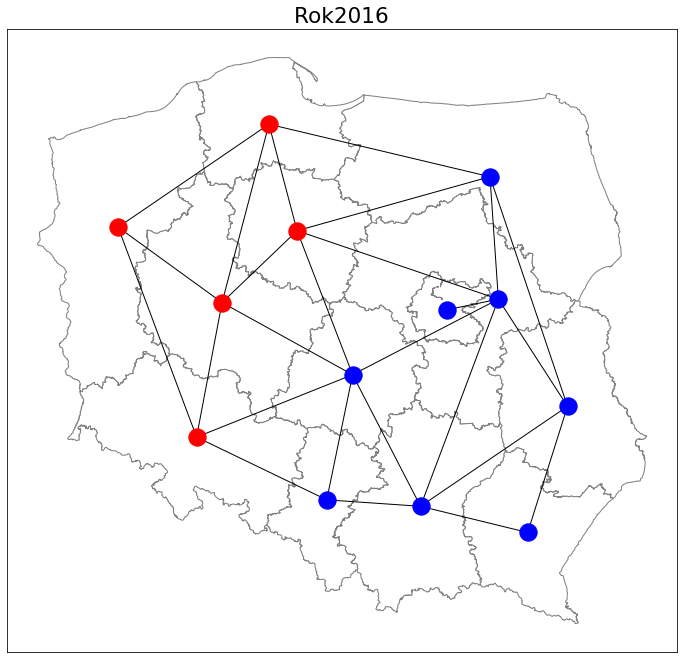

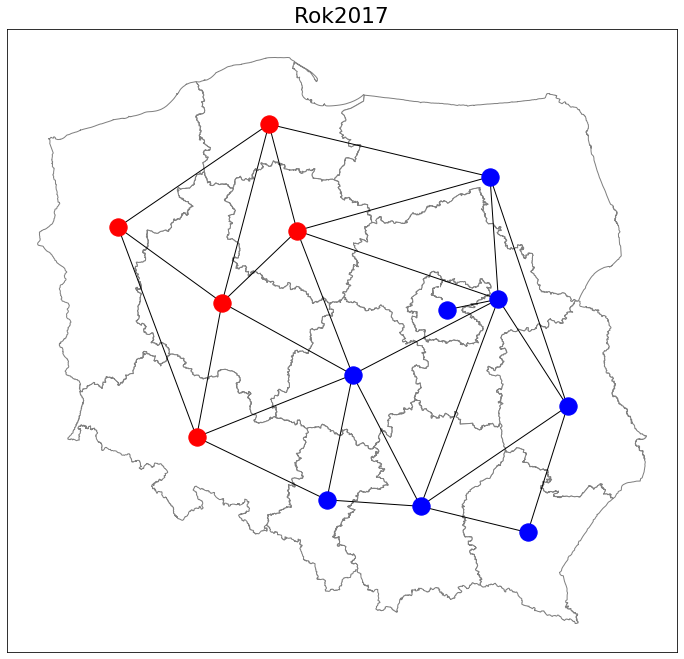

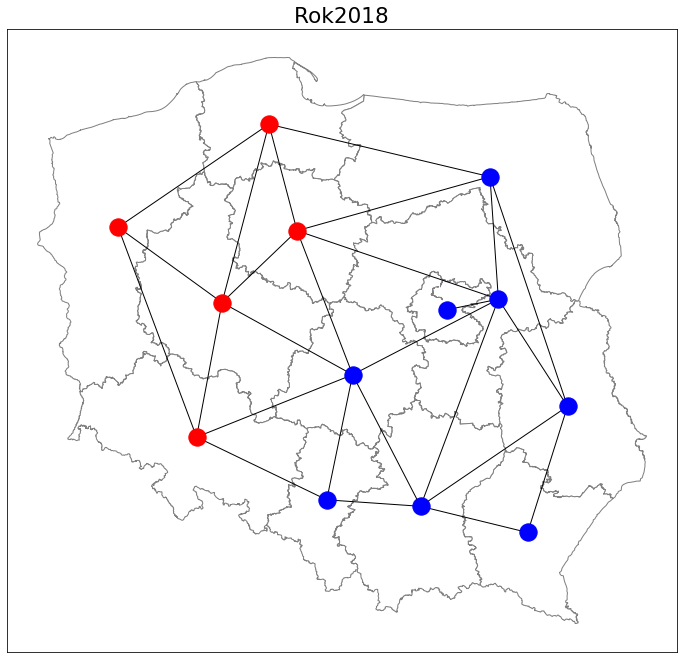

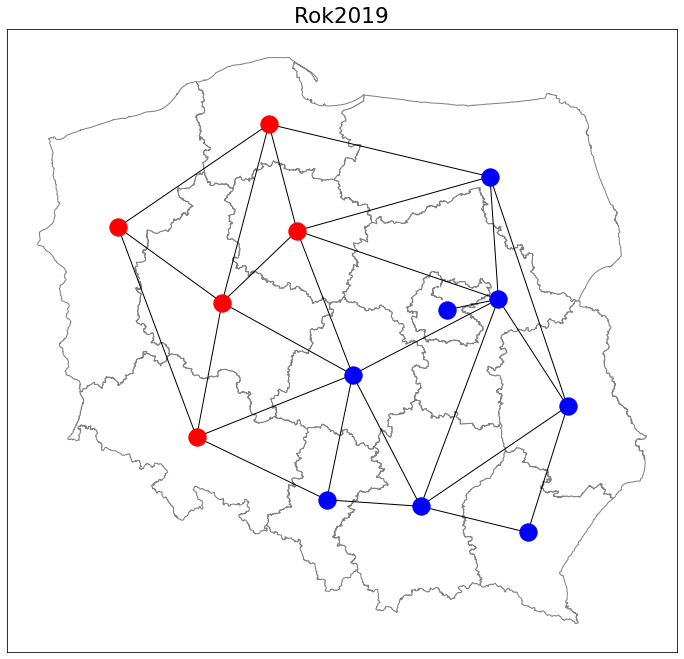

In [77]:
gE = Graph(graph_euro)
gE.opinions = np.ones(len(gE.opinions))
gE.opinions[[3, 4, 7, 8]] = 0
for j in range(15):
        party0, party1 = gE.parties()
        
        plt.rcParams["figure.figsize"] = (12,12)
        ax = euro.plot(edgecolor='grey', facecolor='w')
        nx.draw_networkx_edges(graph_euro, pos_e)
        nx.draw_networkx_nodes(graph_euro, pos_e, nodelist=party0, node_color='b')
        nx.draw_networkx_nodes(graph_euro, pos_e, nodelist=party1, node_color='r')
        gE.one_step(parameter2 ,0.05)
        gE.one_move()
        plt.title('Rok'+str(2004+j+1))
        plt.savefig('polsza/move_every_year_rok'+str(2004+j+1)+'.png', bbox_inches = 'tight')
        if (j+1) % 5 == 0:
            #gE.one_move()
            pass

In [60]:
parameter3 = parameter1
parameter3.reshape(13,2)[5] = parameter2.reshape(13,2)[5]
parameter3.reshape(26)

array([0.02375646, 0.56333821, 0.33915337, 0.41153166, 0.98040977,
       0.47624623, 0.10720248, 0.68684749, 0.26094592, 0.42699389,
       0.51359586, 0.39335118, 0.3500708 , 0.84208368, 0.6054322 ,
       0.48631564, 0.83213648, 0.65673158, 0.8936218 , 0.45612455,
       0.78859259, 0.34438052, 0.30845211, 0.41556457, 0.68815273,
       0.82619374])

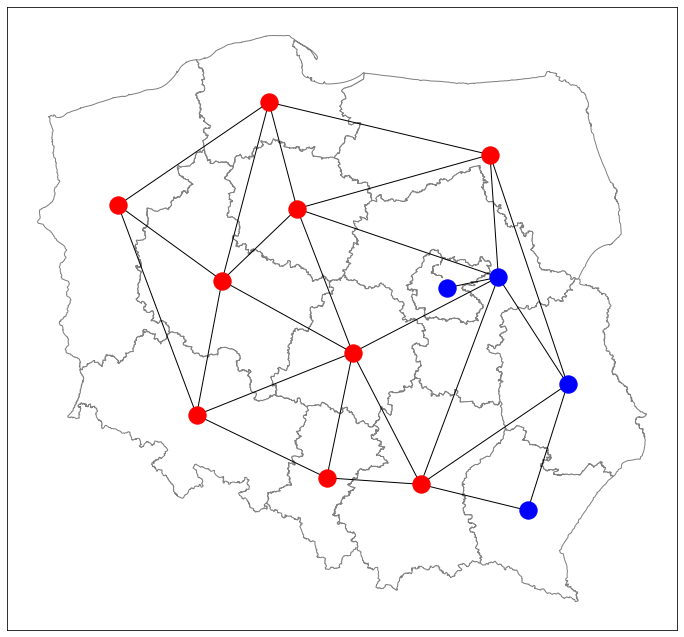

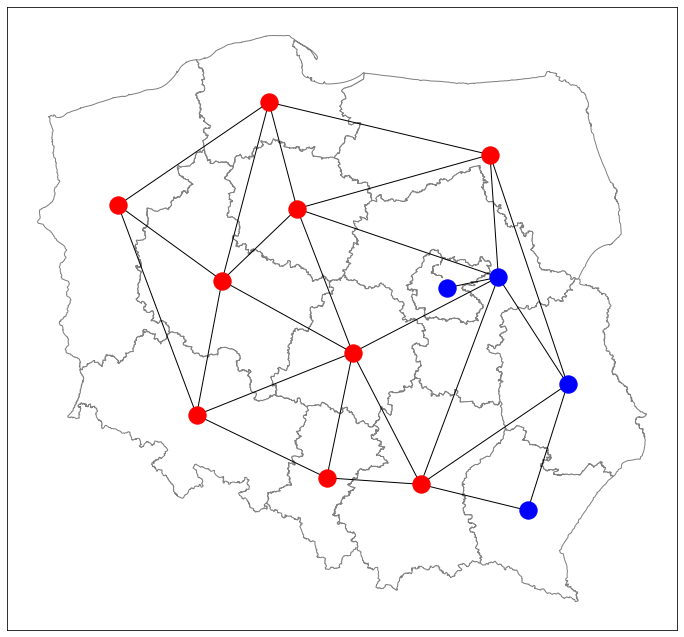

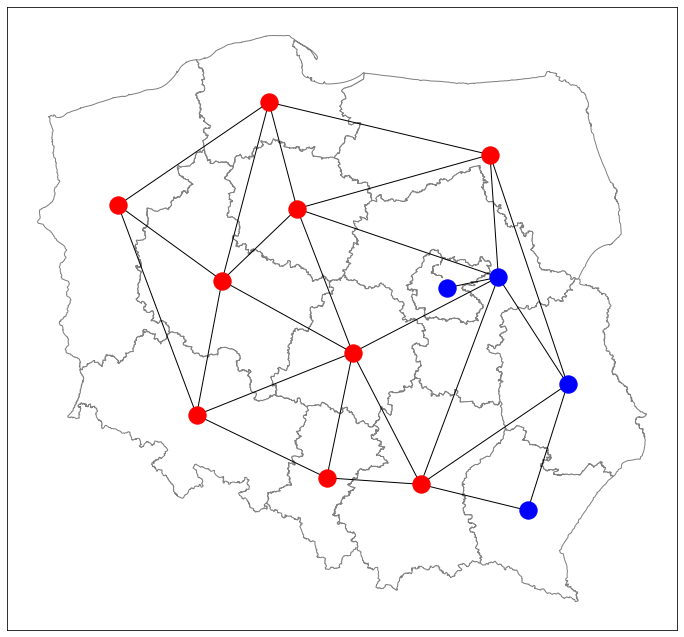

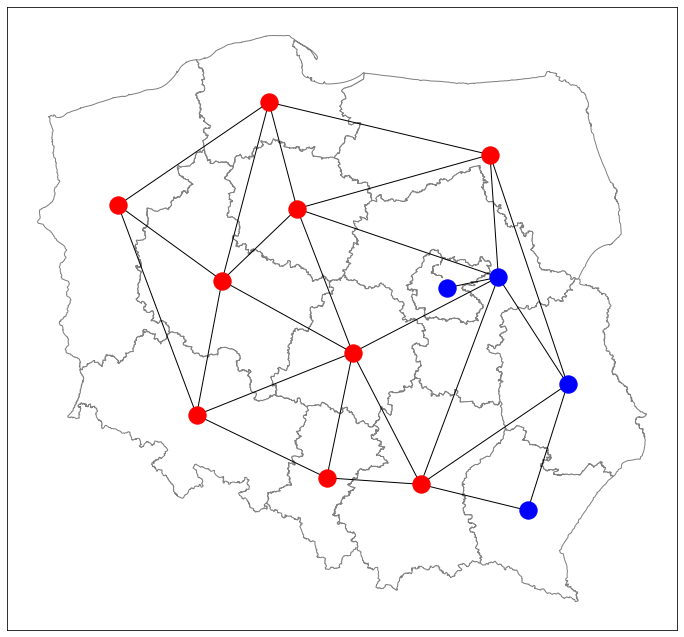

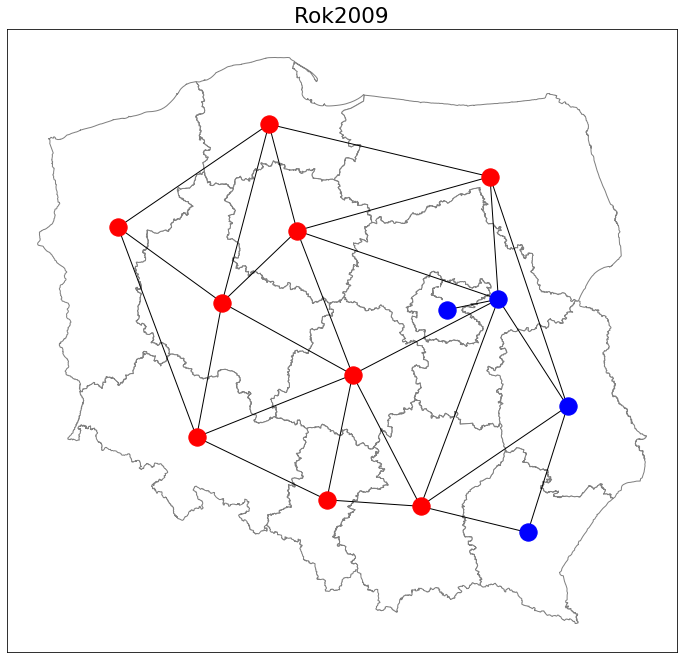

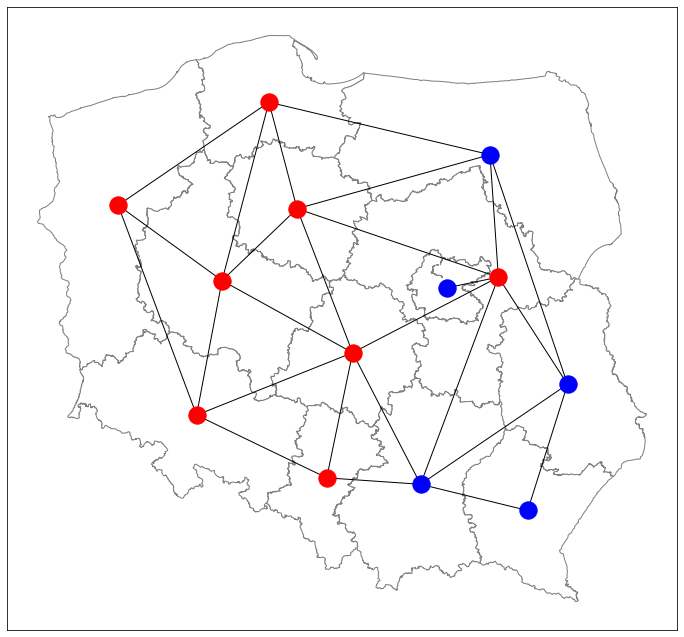

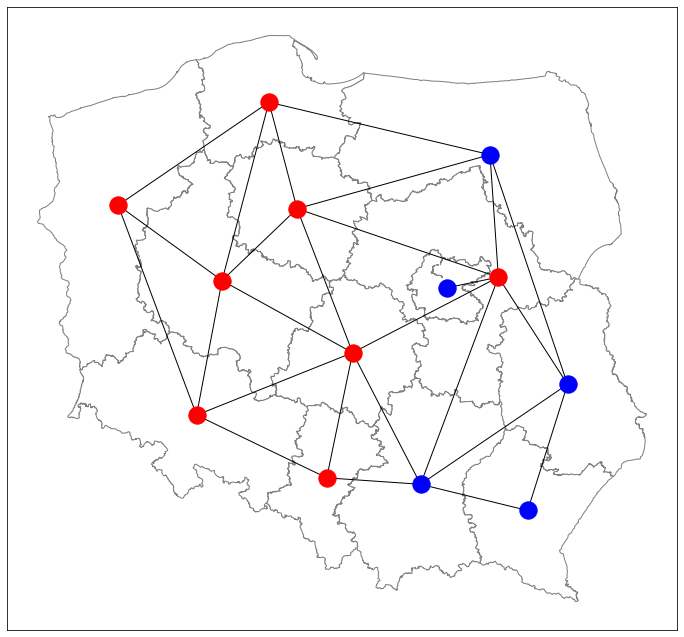

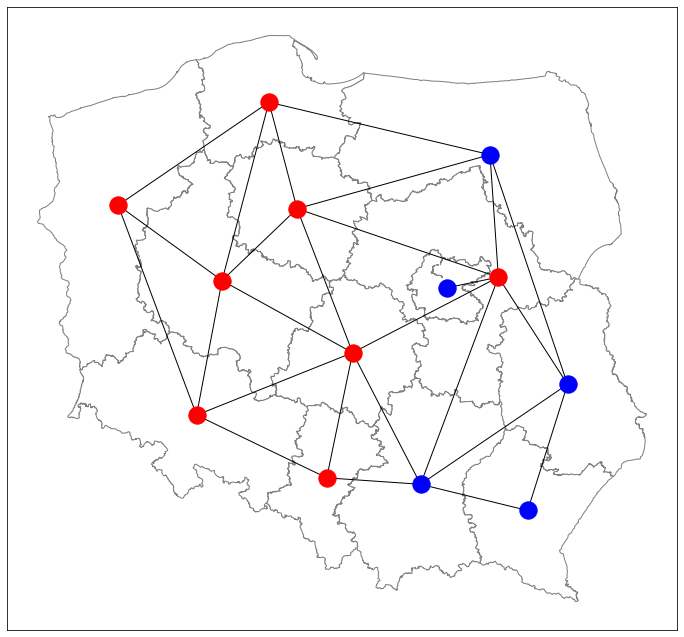

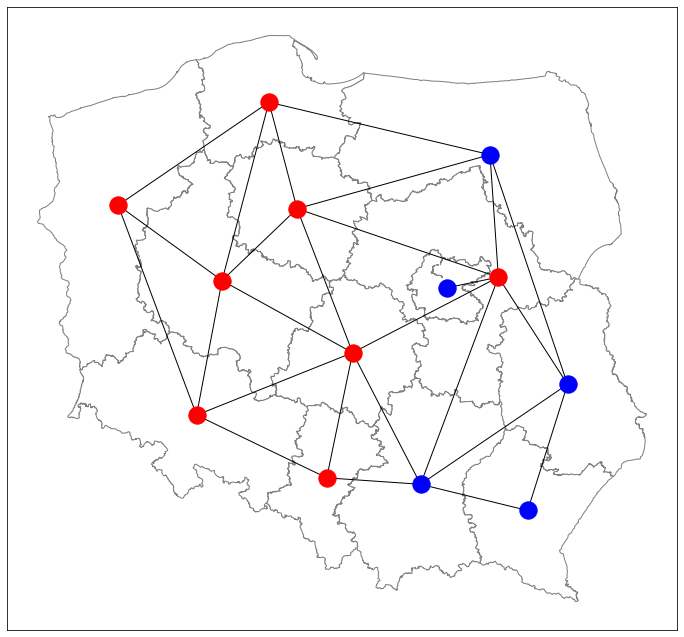

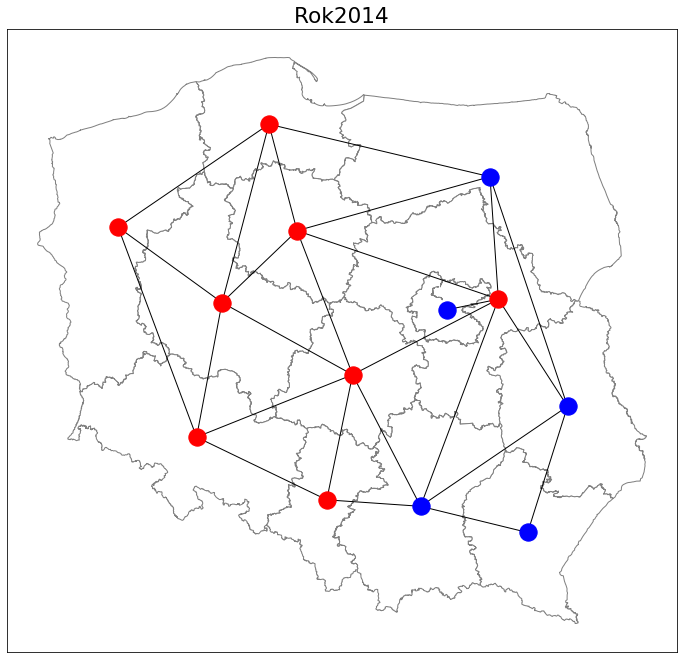

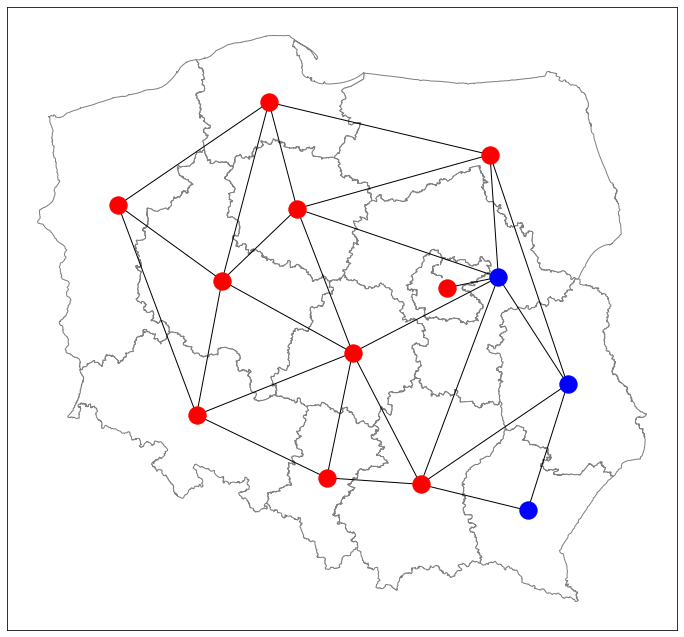

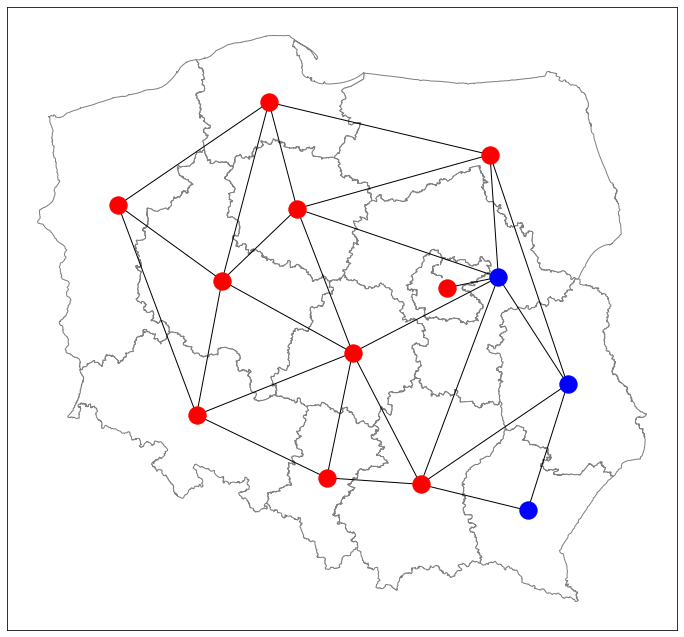

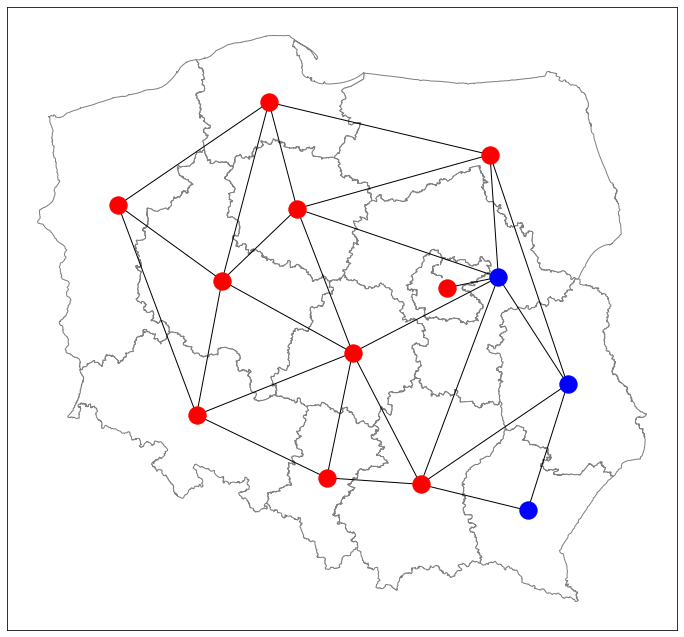

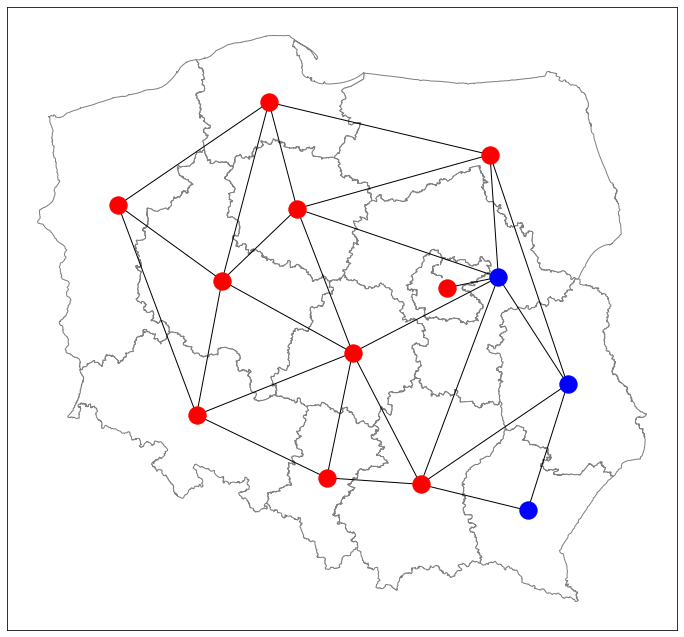

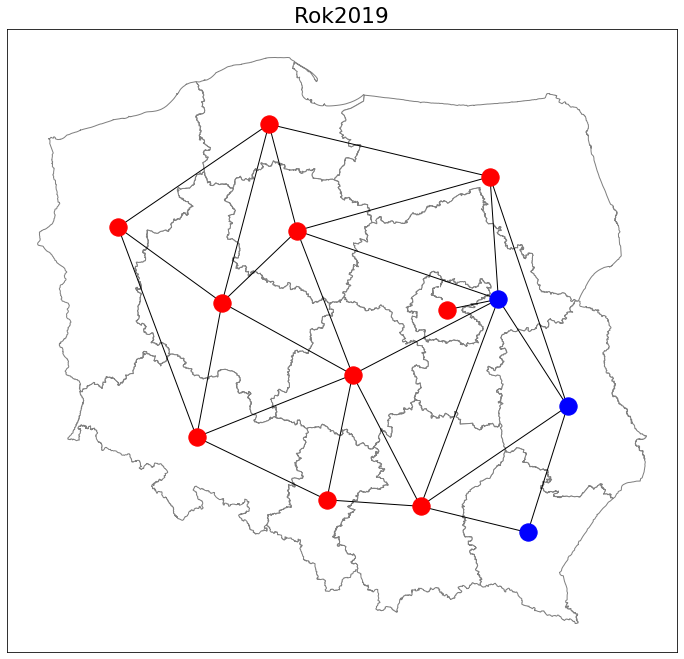

In [61]:
gE = Graph(graph_euro)
gE.opinions = np.ones(len(gE.opinions))
gE.opinions[[3, 4, 7, 8]] = 0
for j in range(15):
        party0, party1 = gE.parties()
        
        plt.rcParams["figure.figsize"] = (12,12)
        ax = euro.plot(edgecolor='grey', facecolor='w')
        nx.draw_networkx_edges(graph_euro, pos_e)
        nx.draw_networkx_nodes(graph_euro, pos_e, nodelist=party0, node_color='b')
        nx.draw_networkx_nodes(graph_euro, pos_e, nodelist=party1, node_color='r')
        gE.one_step(parameter2 ,0.05)
        if (j+1) % 5 == 0:
            gE.one_move()
            plt.title('Rok'+str(2004+j+1))
            plt.savefig('polsza/move_every_4years_paramByHand_rok'+str(2004+j+1)+'.png', bbox_inches = 'tight')